# Evaluate performance when training on one chromosome (e.g. chr 11) and testing on a different chromosome (e.g. chr 20)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import time
from math import sqrt
from sklearn.externals import joblib
from os.path import join

### Set Relevant Paths

In [20]:
data_dir = '../../data'
saved_models_dir = 'saved_models'

## Load Training Data (Chromosome 11)

In [21]:
train_dir = join(data_dir,'processed/chrom11')
train_file = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.11.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels.table'
df_train_full = pd.read_csv(join(train_dir, train_file), sep='\t')

## Load Test Data (Chromosome 20)

In [23]:
# Load the test data (Chrom 20)
test_dir = join(data_dir, 'processed/chrom20')
test_file = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels.table'
df_test = pd.read_csv(join(test_dir, test_file), sep='\t')

In [24]:
print 'Features (some of these may get taken out): ', df_train_full.columns
print '# training examples: ', df_train_full.shape[0]
print '# test examples: ', df_test.shape[0]

Features (some of these may get taken out):  Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ',
       u'POSITIVE_TRAIN_SITE', u'DB', u'FILTER', u'GROUND_TRUTH'],
      dtype='object')
# training examples:  187242
# test examples:  86843


In [25]:
df_train_full = df_train_full.drop('Unnamed: 0', axis=1)  
df_test = df_test.drop('Unnamed: 0', axis=1)

## Split training data into train and test

In [26]:
num_train = df_train_full.shape[0]
idx_train_dev = train_test_split(range(num_train), range(num_train), test_size = 0.3, random_state=0)
idx_train = idx_train_dev[0]
idx_dev = idx_train_dev[1]

In [27]:
df_train = df_train_full.loc[idx_train,:]
df_dev = df_train_full.loc[idx_dev,:]

df_train_Y = df_train['GROUND_TRUTH']
df_train_X = df_train.drop(['GROUND_TRUTH'], axis=1)

df_dev_Y = df_dev['GROUND_TRUTH']
df_dev_X = df_dev.drop(['GROUND_TRUTH'], axis=1)

df_test_Y = df_test['GROUND_TRUTH']
df_test_X = df_test.drop(['GROUND_TRUTH'], axis=1)

df_train_full_Y = df_train_full['GROUND_TRUTH']
df_train_full_X = df_train_full.drop(['GROUND_TRUTH'], axis=1)

# Evaluate VQSR Performance

In [28]:
# See https://software.broadinstitute.org/gatk/guide/article?id=39 for interpretation of tranche labels

LOW_QUAL = 'LowQual'
TRANCHE_99_9 = 'VQSRTrancheSNP99.90to100.00' # if you ignore these and the above, you recover at most 99.9% of all variants. has some low vqslod values
TRANCHE_99 = 'VQSRTrancheSNP99.00to99.90' # if you retain these and ignore the above, you'll recover at most 99% of variants. 
PASS_ALL = 'PASS'  # if you **retain** these and ignore the above, you'll recover at most 90% of the variants

def did_variant_pass_filter(label, tranche):
    return label == PASS_ALL or \
            (tranche == TRANCHE_99 and label == TRANCHE_99) or \
            (tranche == TRANCHE_99_9 and (label == TRANCHE_99 or label == TRANCHE_99_9))
            
def convert_vqsr_labels(raw_labels, tranche=None):
    num_labels = raw_labels.shape[0]
    labels = num_labels * [0]
    for i, label in enumerate(raw_labels):
        if did_variant_pass_filter(label, tranche):
            labels[i] = 1
    return labels        

In [29]:
vqsr_dev_labels = df_dev_X['FILTER']
vqsr_test_labels = df_test_X['FILTER']
vqsr_tranches_uniq = set(df_dev_X['FILTER'])

if LOW_QUAL in vqsr_tranches_uniq:
    vqsr_tranches_uniq -= {LOW_QUAL}

vqsr_tranches_uniq = list(vqsr_tranches_uniq)    

vqsr_prec = np.zeros(len(vqsr_tranches_uniq))
vqsr_recall = np.zeros(len(vqsr_tranches_uniq))
vqsr_f1 = np.zeros(len(vqsr_tranches_uniq))

for i, tranche in enumerate(vqsr_tranches_uniq):
    print 'Tranche: ', tranche
    vqsr_dev_labels_binary = convert_vqsr_labels(vqsr_dev_labels, tranche)
    vqsr_dev_acc = accuracy_score(df_dev_Y, vqsr_dev_labels_binary)
    print 'VQSR Dev Accuracy: ', vqsr_dev_acc
    vqsr_test_labels_binary = convert_vqsr_labels(vqsr_test_labels, tranche)
    vqsr_test_acc = accuracy_score(df_test_Y, vqsr_test_labels_binary)
    print 'VQSR Test Accuracy: ', vqsr_test_acc
    
    vqsr_prec[i] = precision_score(df_test_Y, vqsr_test_labels_binary)
    vqsr_recall[i] = recall_score(df_test_Y, vqsr_test_labels_binary)
    print 'Precision: ', vqsr_prec[i]
    print 'Recall: ', vqsr_recall[i]
    
    
    vqsr_f1[i] = f1_score(df_test_Y, vqsr_test_labels_binary, average='weighted')  
    print 'F1 score: ', vqsr_f1[i]

Tranche:  VQSRTrancheSNP99.00to99.90
VQSR Dev Accuracy:  0.922898901608
VQSR Test Accuracy:  0.925348041869
Precision:  0.943029049544
Recall:  0.96907173811
F1 score:  0.923066278292
Tranche:  VQSRTrancheSNP99.90to100.00
VQSR Dev Accuracy:  0.929467893828
VQSR Test Accuracy:  0.837304100503
Precision:  0.845056258208
Recall:  0.98574346518
F1 score:  0.784819378897
Tranche:  PASS
VQSR Dev Accuracy:  0.886475708971
VQSR Test Accuracy:  0.919463860069
Precision:  0.980068053152
Recall:  0.922230809572
F1 score:  0.923450057531


## Remove VQSR Filter label so that we can run non-VQSR methods

In [30]:
df_train_X = df_train_X.drop(['FILTER'], axis=1)
df_dev_X = df_dev_X.drop(['FILTER'], axis=1)
df_train_full_X = df_train_full_X.drop(['FILTER'], axis=1)
df_test_X = df_test_X.drop(['FILTER'], axis=1)

# Supervised Learning Approaches. Optimize for F1 score using cross-validation (classes are significantly imbalanced, so we should not simple optimize for accuracy)

In [92]:
# Number of folds for cross validation
num_folds = 5

loss_function = 'l2'  # Loss function to use. Must be either 'l1' or 'l2'

In [93]:
def f1_prec_recall(pred, labels, verbose=True):
    f1 = f1_score(pred, labels, average='binary')
    prec = precision_score(pred, labels)
    recall = recall_score(pred, labels)
    
    if verbose:
        # Make a Pandas DataFrame to print results more nicely
        df = pd.DataFrame(data=np.asarray([[f1, prec, recall]]),
                         columns=['F1', 'Precision', 'Recall'])
        print df.to_string(index=False, justify='left')
        
    return f1, prec, recall

## Train the logistic regression classifier. (If you've already ran this notebook, then you can skip this block and just load the saved classifier)

In [94]:
lr_start = time.clock()

lr_params = {'C':np.logspace(1, 7, 20)}
lr_obj = linear_model.LogisticRegression(penalty=loss_function, random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
lr_classifier = GridSearchCV(lr_obj, lr_params, cv=num_folds, scoring='f1')
lr_classifier.fit(df_train_X, df_train_Y)

lr_stop = time.clock()
lr_time_train = lr_stop - lr_start

print 'Logistic Regression CV Time (in seconds): ', lr_time_train

Logistic Regression CV Time (in seconds):  188.916095


In [95]:
# Save the classifier
joblib.dump(lr_classifier, join(saved_models_dir,'lr_classifier'))

['saved_models/lr_classifier']

In [32]:
# Load the saved classifier
lr_classifier = joblib.load(join(saved_models_dir,'lr_classifier'))

In [97]:
print 'Logistic Regression Best Estimator: ', lr_classifier.best_estimator_

Logistic Regression Best Estimator:  LogisticRegression(C=1128837.8916846884, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


## Support Vector Classifier. Train using 3-fold stratified CV with grid search for hyperparameter selection. 

In [115]:
svc_num_folds = 3

svc_start = time.clock()

svc_params = {'C':np.logspace(2, 4, 3), 'gamma':[0.1]}
svc_obj = SVC(kernel='rbf', random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
svc_classifier = GridSearchCV(svc_obj, svc_params, cv=svc_num_folds, scoring='f1')
svc_classifier.fit(df_train_X, df_train_Y)

svc_stop = time.clock()
svc_time_train = svc_stop - svc_start

print 'SVC CV Time (in seconds): ', svc_time_train

SVC CV Time (in seconds):  2225.512002


In [116]:
# Save the classifier
joblib.dump(svc_classifier, join(saved_models_dir,'svc_classifier'))

['saved_models/svc_classifier']

In [34]:
# Load the classifier
svc_classifier = joblib.load(join(saved_models_dir,'svc_classifier'))

In [118]:
print 'Rand Forest Best Estimator: ', svc_classifier.best_estimator_

Rand Forest Best Estimator:  SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


## Random Forest Classifier. Train using 5-fold stratified CV with grid search for hyperparameter selection. 

In [99]:
num_features = df_train_X.shape[1]

rf_start = time.clock()

# Use 20 trees in the forest (if you have the time or resources, consider using more trees)
# However, I've tried up to 50 trees and it makes very little difference on dev set error
rf_params = {"n_estimators":[20], 
             "criterion": ["gini", "entropy"], 
             "max_features": range(int(sqrt(num_features)), num_features, 2)
            }
rf_obj = RandomForestClassifier(random_state=0)

rf_classifier = GridSearchCV(rf_obj, rf_params, cv=num_folds, scoring='f1')
rf_classifier.fit(df_train_X, df_train_Y)

rf_stop = time.clock()
rf_time_train = rf_stop - rf_start

print 'Random Forest CV Time (in seconds): ', rf_time_train

Random Forest CV Time (in seconds):  466.236159


In [100]:
# Save the classifier
joblib.dump(rf_classifier, join(saved_models_dir,'rf_classifier'))

['saved_models/rf_classifier']

In [37]:
rf_classifier = joblib.load(join(saved_models_dir,'rf_classifier'))

In [101]:
print 'Rand Forest Best Estimator: ', rf_classifier.best_estimator_

Rand Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


# Evaluate classifiers on test set. First, we need to retrain classifiers on full dataset using optimal parameters that we found above using cross validation

## Logistic Regression

In [98]:
lr_start = time.clock()

lr_classifier_full = linear_model.LogisticRegression(penalty=loss_function, C=lr_best_est.C)
lr_classifier_full.fit(df_train_full_X, df_train_full_Y) 
lr_pred_test = lr_classifier_full.predict(df_test_X)

lr_stop = time.clock()
lr_time_test = lr_stop - lr_start
print 'Execution Time (in seconds): ', lr_time_test

lr_f1, lr_prec, lr_recall = f1_prec_recall(df_test_Y, lr_pred_test)  

Execution Time (in seconds):  2.717814
F1        Precision  Recall  
0.968601  0.951016   0.986848


## SVC

In [117]:
svc_pred_test = svc_classifier.predict(df_test_X)
svc_f1, svc_prec, svc_recall = f1_prec_recall(df_test_Y, svc_pred_test)  

F1        Precision  Recall  
0.726111  0.857683   0.629537


## Random Forest

In [102]:
rf_start = time.clock()

rf_model_full = RandomForestClassifier(n_estimators=rf_best_est.n_estimators, criterion=rf_best_est.criterion)
rf_model_full.fit(df_train_full_X, df_train_full_Y)
rf_pred_test = rf_model_full.predict(df_test_X)

rf_stop = time.clock()
rf_time_test = rf_stop - rf_start
print 'Execution Time (in seconds): ', rf_time_test

rf_f1, rf_prec, rf_recall = f1_prec_recall(df_test_Y, rf_pred_test)  

Execution Time (in seconds):  6.764
F1        Precision  Recall  
0.950142  0.971612   0.929601


# Plot the Results (don't plot SVM since it performed very poorly)

In [128]:
methods = ['VQSR (99%)', 'VQSR (99.9%)', 'Logisitc Reg', 'Rand Forest']
colors = ['c', 'b', 'r', 'g']
vqsr_tranche_idx_99 = vqsr_tranches_uniq.index(PASS_ALL)
vqsr_tranche_idx_99_9 = vqsr_tranches_uniq.index(TRANCHE_99)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

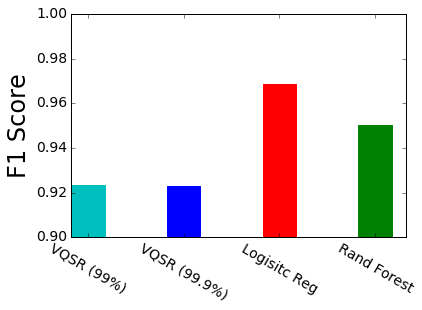

In [129]:
plt.figure()

f1s = [vqsr_f1[vqsr_tranche_idx_99], vqsr_f1[vqsr_tranche_idx_99_9], lr_f1, rf_f1]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, f1s, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('F1 Score', fontsize=24)
plt.show()

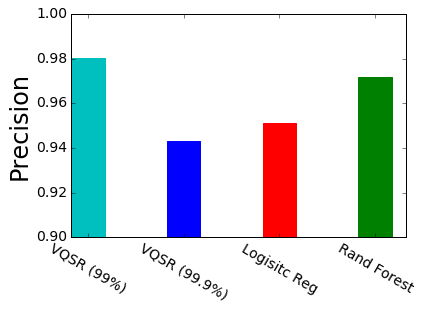

In [130]:
plt.figure()

precs = [vqsr_prec[vqsr_tranche_idx_99], vqsr_prec[vqsr_tranche_idx_99_9], lr_prec, rf_prec]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, precs, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Precision', fontsize=24)
plt.show()


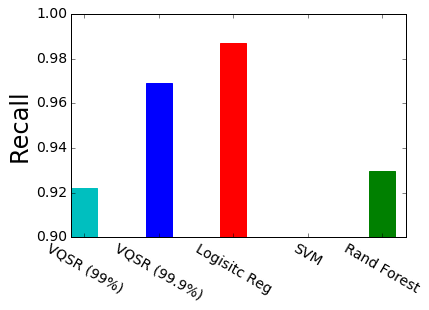

In [125]:
plt.figure()

recalls = [vqsr_recall[vqsr_tranche_idx_99], vqsr_recall[vqsr_tranche_idx_99_9], lr_recall, rf_recall]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, recalls, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Recall', fontsize=24)
plt.show()

## Total Execution Times

In [127]:
lr_total_time = lr_time_train + lr_time_test
svc_total_time = svc_time_train
rf_total_time = rf_time_train + rf_time_test
print 'Total Execution Times:'
print 'Logistic Reg: ', lr_total_time
print 'SVM: ', svc_total_time
print 'Random Forest: ', rf_total_time

Total Execution Times:
Logistic Reg:  191.633909
SVM:  2225.512002
Random Forest:  473.000159
